# Convolutional Autoencoder
Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset.

In [1]:
import torch 
import numpy as np 
from torchvision import datasets
import torchvision.transforms as transforms

In [3]:
transform = transforms.ToTensor()



train_data = datasets.MNIST(root ='data', train= True,
                           download =True, transform = transform)

test_data  = datasets.MNIST(root='data', train = False,
                           download= True, transform= transform)

9920512it [00:03, 2698857.65it/s]                                                                                                                                                                                 


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


32768it [00:00, 88690.09it/s]                                                                                                                                                                                     


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


1654784it [00:01, 1308771.12it/s]                                                                                                                                                                                 


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


8192it [00:00, 31025.46it/s]                                                                                                                                                                                      


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


# Load the data 

In [25]:
num_workers = 0

batch_size = 20


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers= num_workers)


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size , num_workers= num_workers)

# Visualize the data 

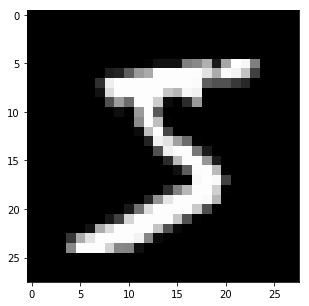

In [33]:
import matplotlib.pyplot as plt

%matplotlib inline 

#
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])


fig = plt.figure(figsize =(5, 5))
ax  = fig.add_subplot(111)
ax.imshow(img, cmap ='gray')



## Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers.

## Decoder
The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        #encoder
        self.conv1 = nn.Conv2d(1 , 16, 3 , padding =1 )
        self.conv2 = nn.Conv2d(16 , 4 , 3, padding =1 )
        self.pool  = nn.MaxPool2d(2 , 2)
        
        #decoder
        self.t_conv1 = nn.ConvTranspose2d(4 , 16 , 2 , stride = 2)
        self.t_conv2 = nn.ConvTranspose2d(16 , 1 , 2 , stride = 2)
        
        

    def forward(self, x ):
    
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        
        return x
        
        
        

In [36]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


## Training


In [37]:
criterion = nn.MSELoss()


optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        #print('type of outputs :', type(outputs) )
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.312064
Epoch: 2 	Training Loss: 0.267611
